In [1]:
# %reset -f

import datetime
import gurobipy as gp
import itertools
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import pickle
import requests
import re
import scipy as sci
import sympy as sym
import warnings

from bs4 import BeautifulSoup
from gurobipy import GRB
from matplotlib.ticker import MultipleLocator
from numpy import sqrt, exp, log, sin, cos, pi
from numba import jit

# 全局绘图样式设置

# 整体风格
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
# 字体
plt.rcParams['font.family'] = 'Times New Roman + Microsoft YaHei'
plt.rcParams['font.size'] = 13
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
# 取消右侧和上方的刻度线
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# 网格设置
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['axes.unicode_minus'] = False
# 主副刻度线
plt.rcParams['axes.linewidth'] = 1.3  # 主刻度线的粗细

plt.rcParams['xtick.major.width'] = 1.3  # x:主刻度:宽度
plt.rcParams['xtick.major.size'] = 5.3     # x:主刻度:长度
plt.rcParams['xtick.minor.width'] = 1.3  # x:副刻度:宽度
plt.rcParams['xtick.minor.size'] = 3     # x:副刻度:长度

plt.rcParams['ytick.major.width'] = 1.3  # y:主刻度:宽度
plt.rcParams['ytick.major.size'] = 5.3     # y:主刻度:长度
plt.rcParams['ytick.minor.width'] = 1.3  # y:副刻度:宽度
plt.rcParams['ytick.minor.size'] = 3     # y:副刻度:长度
# 设置使用latex
plt.rcParams['text.usetex'] = False

warnings.filterwarnings('ignore')

# %matplotlib inline
# matplotlib.use('TkAgg')


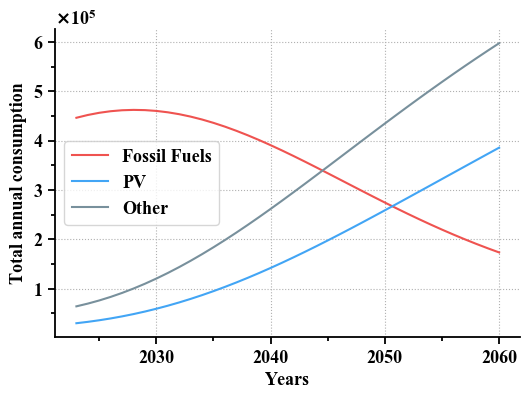

In [16]:
def my_zoom(x, y, ax, axin_size, xlim, ylim, loc):
    # 创建缩放图
    axins = ax.inset_axes(axin_size, transform=ax.transData)
    axins.plot(x, y)
    axins.set_xlim(xlim)
    axins.set_ylim(ylim)
    for key in axins.spines:
        axins.spines[key].set_visible(True)
        axins.spines[key].set_linewidth(0.8)
    axins.tick_params(axis='both', which='both', width=0.8)
    rectpatch, connects=ax.indicate_inset_zoom(axins, linestyle='--', linewidth=1.5, edgecolor='#BDBDBD', alpha=1)
    # 移除所有原来的连线
    for con in connects:
        con.set_visible(False)
    
    # 构建所有框选区域
    ax_pos = [(xlim[0], ylim[1]),(xlim[1], ylim[1]),
              (xlim[0], ylim[0]),(xlim[1], ylim[0])]
    axin_pos = [(axin_size[0], axin_size[1] + axin_size[3]),
                (axin_size[0] + axin_size[2], axin_size[1] + axin_size[3]),
                (axin_size[0], axin_size[1]),
                (axin_size[0] + axin_size[2], axin_size[1])]
    for i in range(4):
        if loc[i] == 0:
            continue
        else:
            ax.plot([ax_pos[i][0], axin_pos[loc[i]-1][0]], 
                    [ax_pos[i][1], axin_pos[loc[i]-1][1]], 
                    linewidth=1.5, linestyle='--', color='#BDBDBD')
            
df_data = pd.read_excel('q4消耗量转化.xlsx')

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_data['time'], df_data['v1'],color='#EF5350')
ax.plot(df_data['time'], df_data['v2'],color='#42A5F5')
ax.plot(df_data['time'], df_data['v3'],color='#78909C')
ax.set_xlabel('Years')
ax.set_ylabel('Total annual consumption')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.legend(['Fossil Fuels','PV','Other'])

from matplotlib.ticker import ScalarFormatter
# 将useMathText设置为True,使得刻度标记显示为科学计数法
y_formatter = ScalarFormatter(useMathText=True)
# 控制刻度标记的科学计数法显示
y_formatter.set_powerlimits((-2, 2))  
ax.yaxis.set_major_formatter(y_formatter)
plt.savefig('消耗量趋势.pdf', bbox_inches='tight')

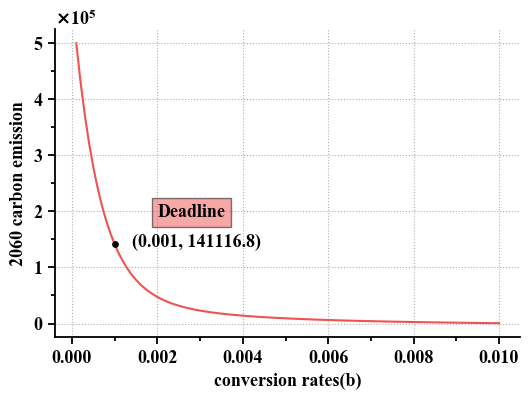

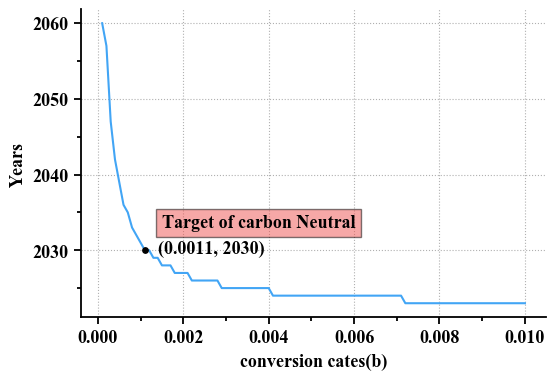

In [62]:
df_data2 = pd.read_excel('碳高峰年份与2060碳排放.xlsx')

bbox = {"facecolor": "#EF5350", "alpha": 0.5}
styles = {"size": 13, "color": "black", "bbox": bbox}

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_data2['conversion rates'], df_data2['2060 carbon emission'],color='#EF5350')

ax.set_xlabel('conversion rates(b)')
ax.set_ylabel('2060 carbon emission')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
from matplotlib.ticker import ScalarFormatter
# 将useMathText设置为True,使得刻度标记显示为科学计数法
y_formatter = ScalarFormatter(useMathText=True)
# 控制刻度标记的科学计数法显示
y_formatter.set_powerlimits((-2, 2))  
ax.yaxis.set_major_formatter(y_formatter)

ax.scatter(0.001, 141116.8079,marker='.',s=60,color='black',zorder=2)
ax.text(0.0014, 139016.8,"(0.001, 141116.8)")
ax.text(0.002, 190000, "Deadline", **styles)
plt.savefig('q4_2060碳排放.pdf', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_data2['conversion rates'], df_data2['year'],color='#42A5F5')
ax.set_xlabel('conversion cates(b)')
ax.set_ylabel('Years')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.scatter(0.0011, 2030,marker='.',s=60,color='black',zorder=2)
ax.text(0.0014, 2029.7,"(0.0011, 2030)")
ax.text(0.0015, 2033, "Target of carbon Neutral", **styles)
plt.savefig('q4_b-year.pdf', bbox_inches='tight')